In [1]:
811/7

115.85714285714286

In [3]:
import time,glob,pickle,cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as snd
from skimage.transform import rescale
from skimage import exposure
from skimage.metrics import structural_similarity as ssim
from skimage.filters import median
from scipy.optimize import leastsq
from iminuit import Minuit

from flam_homo import plot_comparison

rootdir='/home/andrew/work/ccd/20210309-pinhole_flammarion/raw/'



def warp_imp(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpPerspective(im,
                   M,
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    #output_im-=output_im.min()
    #output_im*=1./output_im.max()*255
    return output_im

In [4]:
def plot_comparison(img1,datmask,foowarp,datvmin=0,datvmax=255,modvmin=0.,modvmax=1.):
    plt.subplot(131),plt.imshow(img1,vmin=datvmin,vmax=datvmax,origin='lower',cmap=plt.cm.Greys_r)
    ymask,xmask=np.where(datmask==0)
    plt.contour(1-datmask,cmap=plt.cm.Reds_r)
#    plt.plot(xmask,ymask,'r.',markersize=.01,alpha=.2)
#    plt.imshow(1-datmask,alpha=.5,cmap=plt.cm.Reds,origin='lower')#,plt.colorbar()
    plt.subplot(133),plt.imshow(foowarp,cmap=plt.cm.Blues_r,origin='lower')#,plt.colorbar()
    plt.subplot(132)
    plt.imshow(img1,vmin=datvmin,vmax=datvmax,cmap=plt.cm.Greys_r,origin='lower')
    plt.contour(foowarp,levels=np.linspace(modvmin,modvmax,10),cmap=plt.cm.Blues,extent=[0,img1.shape[1],0,img1.shape[0]],alpha=.4,linewidths=.5)
    #plt.contour(img1,levels=np.linspace(vmin,vmax,dlvls),cmap=plt.cm.Reds)
    #plt.tight_layout()

In [30]:
rsnum='3220'
resizefac=2
ccdedgemask=20
pieceblursig=18.
rafty,raftx,sensy,sensx=rsnum
filename=glob.glob(rootdir+'*R'+rafty+raftx+'_S*'+sensy+sensx+'*-whole.fits')[0]

dat=fits.getdata(filename)
#p0, p1 = np.percentile(dat, (.1, 99.9))
#datscale = exposure.rescale_intensity(dat, in_range=(p0, p1))
#datscale=dat
datscale=rescale(dat,1./resizefac)#cv2.resize(datscale,(np.int(datscale.shape[0]/resizefac),np.int(datscale.shape[1]/resizefac)))
#datblur=snd.gaussian_filter(datscale,4)
#datmed=median_iterate(datscale,niters=60)#median(datblur)
datmed=median(datscale,selem=np.ones((20,20)))
datin=datmed#datblur#datmed#datblur

datmask=fits.getdata(filename.replace('-whole','-mask'))
datmask=rescale(datmask,1./resizefac,preserve_range=True)
#datmask=np.ones((datscale.shape),dtype='uint8')
datmask[:ccdedgemask,:]=0
datmask[:,:ccdedgemask]=0
datmask[-ccdedgemask:,:]=0
datmask[:,-ccdedgemask:]=0

datgmask=np.where(datmask==1)

piece=fits.getdata(filename.replace('-whole','-piece'))#get_piece(ref,rsnum,edge=150)
pieceblur=snd.gaussian_filter(piece.astype('float'),sigma=pieceblursig)
pieceblur=pieceblur[50:-50,50:-50]
piecein=pieceblur/255.


#foowarp,transmat=fit_flam_parallel(rsnum,do_plots=True)

In [37]:
transfit

array([[ 3.49075260e-01,  1.83324537e-03,  4.12503252e+01],
       [-1.83324537e-03,  3.49075260e-01,  3.54285742e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

(<matplotlib.axes._subplots.AxesSubplot at 0x7fde6e6560f0>,
 <matplotlib.colorbar.Colorbar at 0x7fde6e75c748>)

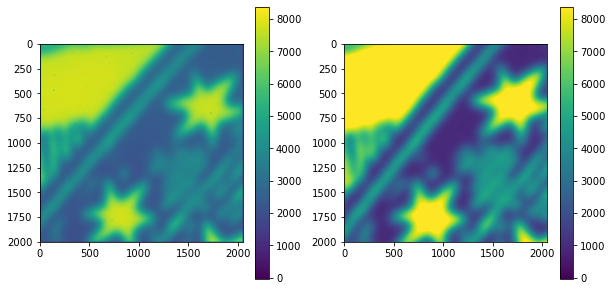

In [21]:
scale0,shear0=.34,-0.01
x0,y0=50.,36.
gain0,bias0=8.5e3,885
transmat0=np.array([[scale0,shear0,x0],[-shear0,scale0,y0],[0.,0.,1.]])
foowarp=warp_imp(piecein, transmat0, datin.shape)
foowarp*=gain0
foowarp+=bias0

plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(datin),plt.colorbar()
plt.subplot(122),plt.imshow(foowarp,vmin=datin.min(),vmax=datin.max()),plt.colorbar()

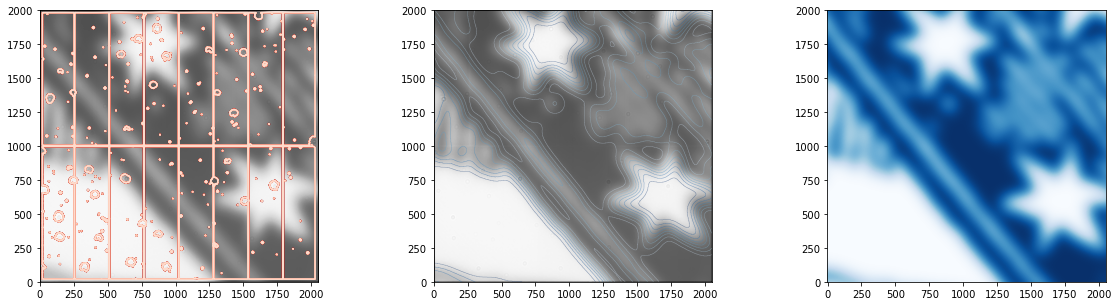

In [22]:
plt.figure(figsize=(20,5))
plot_comparison(datin,datmask*1.,foowarp,datvmin=datin.min(),datvmax=datin.max(),modvmin=datin.min(),modvmax=datin.max())

(<matplotlib.contour.QuadContourSet at 0x7fde6e1ffe10>,
 <matplotlib.colorbar.Colorbar at 0x7fde6e0a4048>)

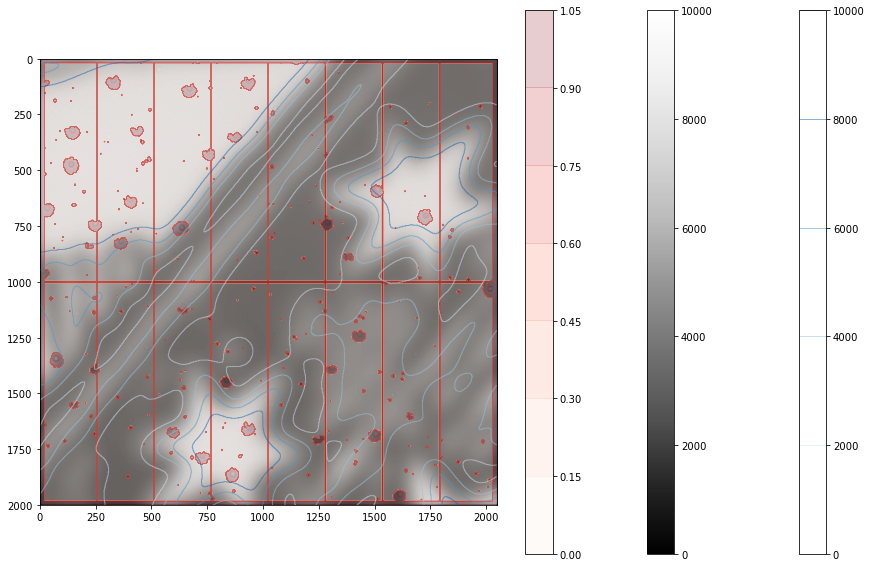

In [23]:
vmin,vmax=0,1e4
nlevels=6
plt.figure(figsize=(16,10))
plt.contour(foowarp,levels=np.linspace(vmin,vmax,nlevels),cmap=plt.cm.Blues,
           linewidths=1,alpha=.5),plt.colorbar()
plt.imshow(datin,vmin=vmin,vmax=vmax,cmap=plt.cm.Greys_r),plt.colorbar()
plt.contourf(1-datmask,cmap=plt.cm.Reds,alpha=.2),plt.colorbar()

In [25]:
def iminuit_fit_func(scale,shear,x,y,bias,gain):
    trans=np.array([[scale,shear,x],[-shear,scale,y],[0.,0.,1.]])
    
    modelwarp=warp_imp(piecein,trans,datin.shape)#.astype(float)
    modelwarp*=gain
    modelwarp+=bias
    
    diff= (datin-modelwarp)[datgmask].flatten()
    chi2=np.sum(diff**2)
    #ss=ssim(datmed,modelwarp)
    return chi2#1.-ss

def init_minuit():
    m=Minuit(iminuit_fit_func,scale=scale0,shear=shear0,x=x0,y=y0,bias=bias0,gain=gain0)
    m.errordef = Minuit.LEAST_SQUARES#LIKELIHOOD

    dscale=.1
    dxy=100
    m.values['scale']=scale0
    #m.limits['scale']=(scale0-dscale,scale0+dscale)
    m.errors['scale']=.1
    #m.fixed['z1']=True

    m.values['shear']=shear0
    #m.limits['shear']=(-.15,.15)
    m.errors['shear']=.001
    #m.fixed['shear']=True

    m.values['x']=x0
    #m.limits['x']=(x0-dxy,x0+dxy)
    m.errors['x']=dxy/5.

    m.values['y']=y0
    #m.limits['y']=(y0-dxy,y0+dxy)
    m.errors['y']=dxy/5.

    m.values['bias']=bias0
    #m.limits['bias']=(.001,.5)#(y0-dxy,y0+dxy)
    m.errors['bias']=100
    #m.fixed['bias']=True

    m.errors['gain']=gain0
    m.errors['gain']=1000.
    #m.limits['gain']=[1e3,20e3]
    #m.fixed['gain']=True
    return m
#m.print_param()
#chi2 = probfit.Chi2Regression(makeStar_iminuit, np.array(x0), stamp.flatten(), np.sqrt(stamp).flatten())
#out = leastsq(fit_func, x0, args=(stamp),maxfev=600, full_output=True)

In [32]:
tstart=time.time()
m=init_minuit()
m.simplex().migrad()

#

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.234e+11                  │              Nfcn = 922              │
│ EDM = 1.17e+04 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│INVALID Minimum│ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ scale │349.07526045e-3│0.00000030e-3│            │            │         │         │       │
│ 1 │ shear │1.833245374e-3│0.000000011e-3│            │            │         │         │       │
│ 2 │ x     │41.25032516│0.00000005 │            │            │         │         │       │
│ 3 │ y     │35.42857422│0.00000006 │            │            │         │         │       │
│ 4 │ bias  │1.8883675e3│0.0000009e3│            │            │         │         │       │
│ 5 │ gain  │5.6801299e3│0.0000016e3│            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     scale     shear         x         y      bias      gain │
├───────┼─────────────────────────────────────────────────────────────┤
│ scale │  9.16e-20  1.91e-21   6.6e-18  8.85e-18  1.13e-16  5.11e-16 │
│ shear │  1.91e-21  1.17e-22  2.87e-19  3.33e-19  4.17e-18  6.28e-18 │
│     x │   6.6e-18  2.87e-19  2.79e-15  9.25e-16  9.31e-15  2.53e-14 │
│     y │  8.85e-18  3.33e-19  9.25e-16  4.12e-15  2.83e-14  1.24e-14 │
│  bias │  1.13e-16  4.17e-18  9.31e-15  2.83e-14  7.39e-07 -1.09e-06 │
│  gain │  5.11e-16  6.28e-18  2.53e-14  1.24e-14 -1.09e-06   2.5e-06 │
└───────┴─────────────────────────────────────────────────────────────┘

In [33]:
print(time.time()-tstart)
print(m.values,m.errors)

42.40385627746582
<ValueView scale=0.3490752604526776 shear=0.001833245373818843 x=41.25032515942945 y=35.428574216213796 bias=1888.3674961529318 gain=5680.129918771178> <ErrorView scale=3.026403207307077e-10 shear=1.0817809372833235e-11 x=5.283498096981142e-08 y=6.418585119695853e-08 bias=0.0008598365731603419 gain=0.0015802166166037819>


In [34]:
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 2.234e+11                  │              Nfcn = 970              │
│ EDM = 1.04e+06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ scale │349.07526045e-3│0.00000034e-3│            │            │         │         │       │
│ 1 │ shear │1.833245374e-3│0.000000012e-3│            │            │         │         │       │
│ 2 │ x     │41.25032516│0.00000018 │            │            │         │         │       │
│ 3 │ y     │35.42857422│0.00000015 │            │            │         │         │       │
│ 4 │ bias  │1.8883675e3│0.0000009e3│            │            │         │         │       │
│ 5 │ gain  │5.6801299e3│0.0000016e3│            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     scale     shear         x         y      bias      gain │
├───────┼─────────────────────────────────────────────────────────────┤
│ scale │  1.13e-19  2.47e-21  2.58e-17  2.91e-17  2.32e-16  6.13e-16 │
│ shear │  2.47e-21  1.46e-22  9.34e-19  8.25e-19  7.87e-18   9.4e-18 │
│     x │  2.58e-17  9.34e-19  3.41e-14  7.42e-15  1.25e-13  1.05e-13 │
│     y │  2.91e-17  8.25e-19  7.42e-15  2.16e-14  1.01e-13   9.4e-14 │
│  bias │  2.32e-16  7.87e-18  1.25e-13  1.01e-13  7.39e-07 -1.09e-06 │
│  gain │  6.13e-16   9.4e-18  1.05e-13   9.4e-14 -1.09e-06   2.5e-06 │
└───────┴─────────────────────────────────────────────────────────────┘

(<ValueView scale=0.6948425337199705 shear=0.0013250200405411226 x=37.4690660440272 y=44.13508348080736 bias=0.06473394680083025 gain=8720.722303280852>,
 <ErrorView scale=4.577277813747482e-08 shear=4.914200251463497e-08 x=4.343463528837937e-05 y=9.085264148921947e-06 bias=1.8302843515775839e-06 gain=0.018448716731117233>)

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


[[ 3.49075260e-01  1.83324537e-03  4.12503252e+01]
 [-1.83324537e-03  3.49075260e-01  3.54285742e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.02669194 -1.18332454 -0.1749935 ]
 [-1.18332454  0.02669194 -0.01587294]
 [        nan         nan  0.        ]]


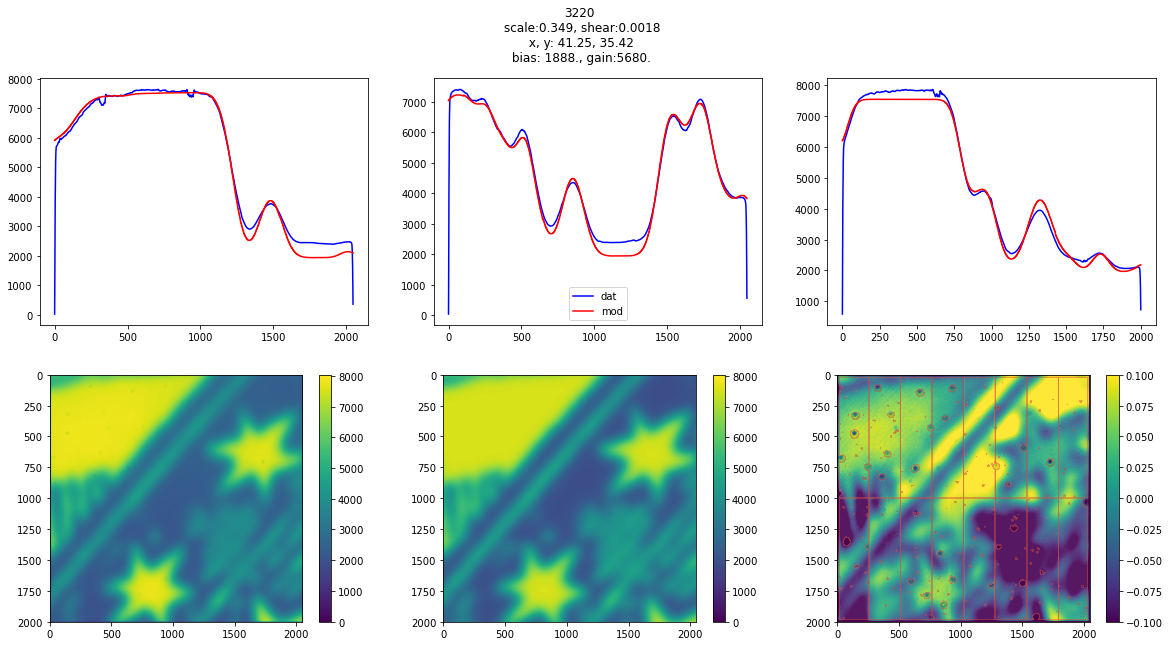

In [36]:
scalefit,shearfit,xfit,yfit,biasfit,gainfit=np.array(m.values)
transfit=np.array([[scalefit,shearfit,xfit],[-shearfit,scalefit,yfit],[0.,0.,1.]])
fitwarp=warp_imp(piecein,transfit,datin.shape)#.astype(float)

fitwarp*=gainfit
fitwarp+=biasfit

print(transfit,(transfit-transmat0)/transmat0)



#plt.imshow(fitwarp)

plt.figure(figsize=(20,10))
plt.suptitle(rsnum+'\n scale:'+str(scalefit)[:5]+', shear:'+str(shearfit)[:6]+
             '\n x, y: '+str(xfit)[:5]+', '+str(yfit)[:5]+
             '\n bias: '+str(biasfit)[:5]+', gain:'+str(gainfit)[:5],fontsize=12)
plt.subplot(231)
plt.plot(datin[100,:],'b',label='dat')
plt.plot(fitwarp[100,:],'r',label='mod')
#plt.legend()
plt.subplot(232)
plt.plot(datin[800,:],'b',label='dat')
plt.plot(fitwarp[800,:],'r',label='mod')
plt.legend()
plt.subplot(233)
plt.plot(datin[:,400],'b')
plt.plot(fitwarp[:,400],'r')

#plt.axvline(40),plt.axvline(1000-40)

plt.subplot(234)
plt.imshow(datin),plt.colorbar()
plt.subplot(235)
plt.imshow(fitwarp,vmin=datin.min(),vmax=datin.max()),plt.colorbar()
plt.subplot(236)
plt.imshow((datin-fitwarp)/np.median(datin),vmin=-.1,vmax=.1),plt.colorbar()
plt.contourf(1-datmask,cmap=plt.cm.Reds,alpha=.1)
plt.savefig(rootdir+rsnum+'-compare.jpg',dpi=150)


fits.writeto(rootdir+rsnum+'-dat.fits',datin,overwrite=True)
#fits.writeto(rootdir+'foomedz.fits',datmedz,overwrite=True)
fits.writeto(rootdir+rsnum+'-mask.fits',datmask,overwrite=True)
#fits.writeto(rootdir+'foowarp.fits',foowarp,overwrite=True)
fits.writeto(rootdir+rsnum+'-fit.fits',fitwarp,overwrite=True)

[[ 6.96187981e-01  1.80958490e-05  3.24011689e+01]
 [-1.80958490e-05  6.96187981e-01  3.23662238e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[ 0.00896809 -1.00180958 -0.35197662]
 [-1.00180958  0.00896809 -0.10093823]
 [        nan         nan  0.        ]]


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


(<matplotlib.image.AxesImage at 0x7f1ecb668390>,
 <matplotlib.colorbar.Colorbar at 0x7f1e9b7bbb00>)

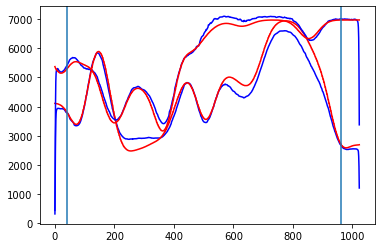

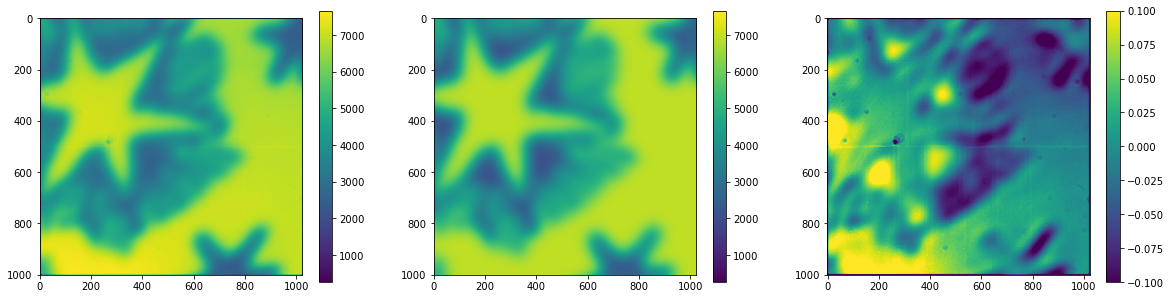

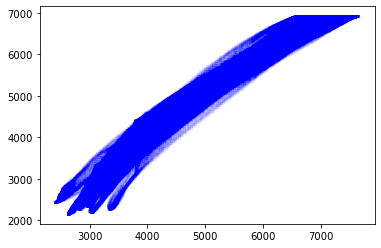

In [536]:
plt.plot(datin[datgmask].flatten(),fitwarp[datgmask].flatten(),'b.',alpha=.005)

In [38]:
picklename='/home/andrew/work/ccd/20210309-pinhole_flammarion/andynorm/20210310-pos_foo.pickle'
with open(picklename, 'rb') as handle: posfoo= pickle.load(handle)
fookeys=[fookey for fookey in posfoo.keys()]


In [39]:
fookeys0=fookeys.copy()

In [40]:
import random

In [41]:
random.shuffle(fookeys)

In [ ]:
tstart=time.time()
for rsnum in fookeys:
    rafty,raftx,sensy,sensx=rsnum
    filename=glob.glob(rootdir+'*R'+rafty+raftx+'_S*'+sensy+sensx+'*-whole.fits')[0]

    dat=fits.getdata(filename)
    #p0, p1 = np.percentile(dat, (.1, 99.9))
    #datscale = exposure.rescale_intensity(dat, in_range=(p0, p1))
    #datscale=dat
    datscale=rescale(dat,1./resizefac)#cv2.resize(datscale,(np.int(datscale.shape[0]/resizefac),np.int(datscale.shape[1]/resizefac)))
    #datblur=snd.gaussian_filter(datscale,4)
    #datmed=median_iterate(datscale,niters=60)#median(datblur)
    datmed=median(datscale,selem=np.ones((20,20)))
    datin=datmed#datblur#datmed#datblur

    datmask=fits.getdata(filename.replace('-whole','-mask'))
    datmask=rescale(datmask,1./resizefac,preserve_range=True)
    #datmask=np.ones((datscale.shape),dtype='uint8')
    datmask[:ccdedgemask,:]=0
    datmask[:,:ccdedgemask]=0
    datmask[-ccdedgemask:,:]=0
    datmask[:,-ccdedgemask:]=0

    datgmask=np.where(datmask==1)

    piece=fits.getdata(filename.replace('-whole','-piece'))#get_piece(ref,rsnum,edge=150)
    pieceblur=snd.gaussian_filter(piece.astype('float'),sigma=pieceblursig)
    pieceblur=pieceblur[50:-50,50:-50]
    piecein=pieceblur/255.

    tstart=time.time()
    m=init_minuit()
    m.simplex().migrad()
    m.hesse()
    
    scalefit,shearfit,xfit,yfit,biasfit,gainfit=np.array(m.values)
    transfit=np.array([[scalefit,shearfit,xfit],[-shearfit,scalefit,yfit],[0.,0.,1.]])
    fitwarp=warp_imp(piecein,transfit,datin.shape)#.astype(float)
    
    fitwarp*=gainfit
    fitwarp+=biasfit
    print(rsnum,time.time()-tstart)



    #plt.imshow(fitwarp)

    plt.figure(figsize=(20,10))
    plt.suptitle(rsnum+'\n scale:'+str(scalefit)[:5]+', shear:'+f"{shearfit:.6f}"+
                 '\n x, y: '+str(xfit)[:5]+', '+str(yfit)[:5]+
                 '\n bias: '+str(biasfit)[:5]+', gain:'+str(gainfit)[:5],fontsize=12)
    plt.subplot(231)
    plt.plot(datin[100,:],'b',label='dat')
    plt.plot(fitwarp[100,:],'r',label='mod')
    #plt.legend()
    plt.subplot(232)
    plt.plot(datin[800,:],'b',label='dat')
    plt.plot(fitwarp[800,:],'r',label='mod')
    plt.legend()
    plt.subplot(233)
    plt.plot(datin[:,400],'b')
    plt.plot(fitwarp[:,400],'r')

    #plt.axvline(40),plt.axvline(1000-40)

    plt.subplot(234)
    plt.imshow(datin),plt.colorbar()
    plt.subplot(235)
    plt.imshow(fitwarp,vmin=datin.min(),vmax=datin.max()),plt.colorbar()
    plt.subplot(236)
    plt.imshow((datin-fitwarp)/np.median(datin),vmin=-.1,vmax=.1),plt.colorbar()
    plt.contourf(1-datmask,cmap=plt.cm.Reds,alpha=.1)
    plt.savefig(rootdir+rsnum+'-compare.jpg',dpi=150)
    plt.close()

    fits.writeto(rootdir+rsnum+'-trans-hires.fits',np.array(m.values),overwrite=True)
    fits.writeto(rootdir+rsnum+'-transerr-hires.fits',np.array(m.errors),overwrite=True)
    fits.writeto(rootdir+rsnum+'-dat-hires.fits',datin,overwrite=True)
    #fits.writeto(rootdir+'foomedz.fits',datmedz,overwrite=True)
    fits.writeto(rootdir+rsnum+'-mask-hires.fits',datmask,overwrite=True)
    #fits.writeto(rootdir+'foowarp.fits',foowarp,overwrite=True)
    fits.writeto(rootdir+rsnum+'-fit-hires.fits',fitwarp,overwrite=True)

#print(time.time()-tstart)
#foowarp,transmat=fit_flam_parallel(rsnum,do_plots=True)

1300 45.60270380973816
1111 35.43784546852112
4220 38.52746796607971
2001 76.810964345932
3221 34.522274017333984
1212 36.129643201828
4111 80.07011294364929
3010 99.21013379096985
3211 60.3497474193573
4121 35.79710268974304
3402 63.86617112159729
1312 50.04802346229553
3212 42.495757818222046
0121 76.36975932121277
1001 82.93536114692688
3220 52.60264873504639
3120 60.29931426048279
4310 61.47128677368164
0320 87.36265254020691
4101 101.35669779777527
3411 58.88308835029602
1012 39.961631298065186
3122 86.61845183372498
2311 46.184688091278076
1102 52.130884408950806
4110 101.31348538398743
1120 45.39873695373535
4221 32.578490257263184
1422 43.812047719955444
4102 56.41594648361206
1320 55.77811336517334
0300 16.6808500289917
2111 50.02495288848877
1310 57.474628925323486
3011 61.760239362716675
2210 66.22165131568909
4300 77.09198021888733
1220 56.01853156089783
3320 60.93066716194153
2310 55.41543245315552
3100 58.189090728759766
3400 69.73719120025635
4320 67.8993604183197
1100 4

In [633]:
m.hesse()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 7.526e+10                  │             Nfcn = 8786              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ scale │ 6.9266e-1 │    nan    │    nan     │    nan     │         │         │       │
│ 1 │ shear │ 1.8516e-3 │    nan    │    nan     │    nan     │         │         │       │
│ 2 │ x     │  4.455e1  │    nan    │    nan     │    nan     │         │         │       │
│ 3 │ y     │  4.902e1  │    nan    │    nan     │    nan     │         │         │       │
│ 4 │ bias  │ 8.8519e2  │    nan    │            │            │         │         │       │
│ 5 │ gain  │ 8.3318e3  │    nan    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         scale         │         shear         │           x           │           y           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    nan    │    nan    │    nan    │    nan    │    nan    │    nan    │    nan    │    nan    │
│  Valid   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────┐
│       │ scale shear     x     y  bias  gain │
├───────┼─────────────────────────────────────┤
│ scale │   nan   nan   nan   nan   nan   nan │
│ shear │   nan   nan   nan   nan   nan   nan │
│     x │   nan   nan   nan   nan   nan   nan │
│     y │   nan   nan   nan   nan   nan   nan │
│  bias │   nan   nan   nan   nan   nan   nan │
│  gain │   nan   nan   nan   nan   nan   nan │
└───────┴─────────────────────────────────────┘

In [ ]:
f'{a:.20f}'

In [595]:
foo=fits.getdata(rootdir+'2312-fittrans')[1]

In [596]:
f"{foo:.6f}"

'0.000045'